# 時間型資料之特徵工程

作業程式碼
本範例將使用 UCI 資料平台中的 Beijing PM2.5 Data 提供的資料集，連結如下：https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data 

請完成以下數個技巧的操作：
1. 透過 Linear Regression 補值
2. 透過 差補法 補植
3. 差分（Differencing）
4. 移動平均（Moving Average）

In [1]:
import numpy as np
import pandas as pd

## 輸入資料

In [25]:
# 輸入資料 
raw_data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   year    41757 non-null  int64  
 2   month   41757 non-null  int64  
 3   day     41757 non-null  int64  
 4   hour    41757 non-null  int64  
 5   pm2.5   41638 non-null  float64
 6   DEWP    41757 non-null  int64  
 7   TEMP    41757 non-null  float64
 8   PRES    41757 non-null  float64
 9   cbwd    41757 non-null  object 
 10  Iws     41757 non-null  float64
 11  Is      41757 non-null  int64  
 12  Ir      41757 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.1+ MB


In [26]:
raw_data["pm2.5"].head(3)

0    129.0
1    148.0
2    159.0
Name: pm2.5, dtype: float64

In [30]:
raw_data["pm2.5"].isnull().value_counts()

pm2.5
False    41638
True       119
Name: count, dtype: int64

In [28]:
time_features = ["year", "month", "day", "hour"]

df_train = raw_data[raw_data["pm2.5"].notna()]
df_missing = raw_data[raw_data["pm2.5"].isna()]

X_train = df_train[time_features]
y_train = df_train["pm2.5"]

## 目標一：透過 Linear Regression (非線性插補，而是將時間作為自變數)將 pm2.5 欄位進行補值

In [19]:
from sklearn.linear_model import LinearRegression

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
X_missing = df_missing[time_features]
pm25_pred = lr.predict(X_missing)

In [23]:
raw_data.loc[raw_data["pm2.5"].isna(), "pm2.5"] = pm25_pred

In [24]:
raw_data["pm2.5"].isna().value_counts()

pm2.5
False    41757
Name: count, dtype: int64

## 目標二：透過 差補法(時間加權) 把 pm2.5 欄位進行補值

In [29]:
raw_data["datetime"] = pd.to_datetime(
    raw_data[["year", "month", "day", "hour"]]
)
raw_data = raw_data.sort_values("datetime")
raw_data = raw_data.set_index("datetime")
raw_data.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,,,,,
2010-01-02 00:00:00,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0


In [31]:
raw_data["pm2.5_interp"] = raw_data["pm2.5"].interpolate(method="time")

In [32]:
raw_data["pm2.5_interp"].isna().value_counts()

pm2.5_interp
False    41757
Name: count, dtype: int64

## 目標三：挑選其中一個數值欄位，進行三階差分、五階差分，並分別繪製出原始資料與差分後資料的折線圖

In [34]:
import matplotlib.pyplot as plt

In [33]:
pm25 = raw_data["pm2.5_interp"]
pm25_diff_3 = pm25.diff(3)
pm25_diff_5 = pm25.diff(5)

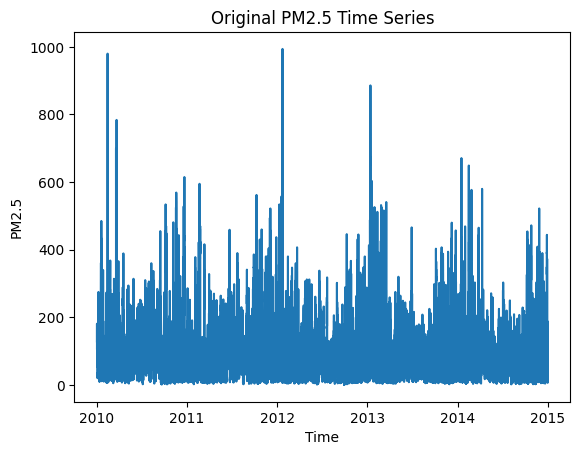

In [35]:
plt.figure()
plt.plot(pm25)
plt.title("Original PM2.5 Time Series")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.show()

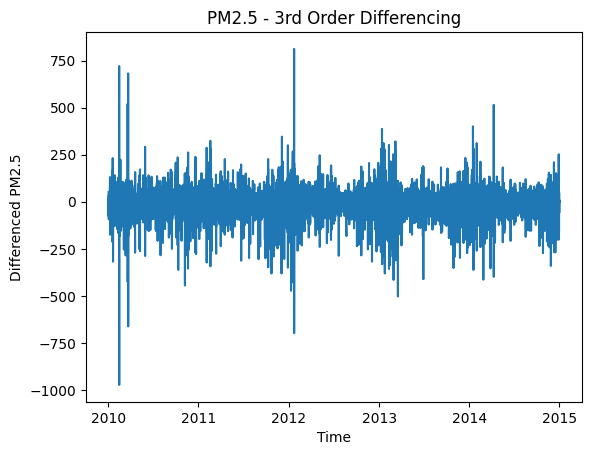

In [36]:
plt.figure()
plt.plot(pm25_diff_3)
plt.title("PM2.5 - 3rd Order Differencing")
plt.xlabel("Time")
plt.ylabel("Differenced PM2.5")
plt.show()

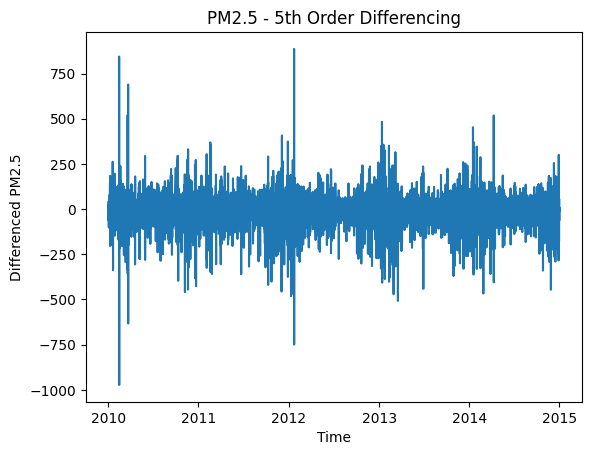

In [37]:
plt.figure()
plt.plot(pm25_diff_5)
plt.title("PM2.5 - 5th Order Differencing")
plt.xlabel("Time")
plt.ylabel("Differenced PM2.5")
plt.show()

## 目標四：挑選其中一個數值欄位，進行移動平均，window 分別為 3 跟 6，並分別繪製出原始資料與差分後資料的折線圖

In [41]:
pres = raw_data["PRES"]

In [54]:
pres_ma_3 = pres.rolling(window=3).mean()
pres_ma_6 = pres.rolling(window=6).mean()

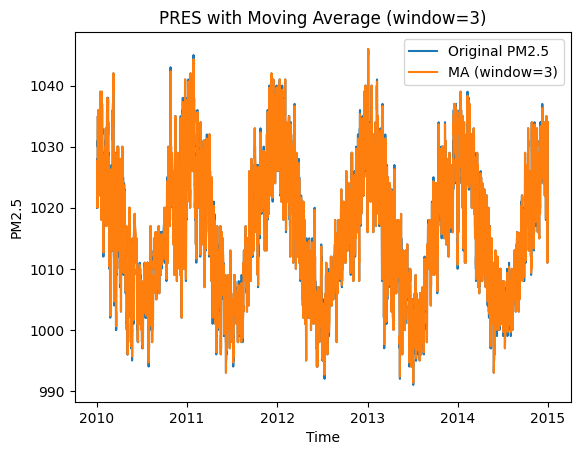

In [52]:
plt.figure()
plt.plot(pres, label="Original PM2.5", alpha=1)
plt.plot(pres_ma_3, label="MA (window=3)")
plt.title("PRES with Moving Average (window=3)")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.show()

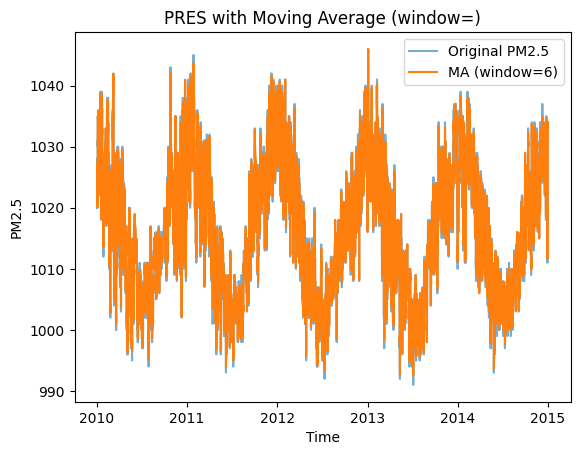

In [55]:
plt.figure()
plt.plot(pres, label="Original PM2.5", alpha=0.6)
plt.plot(pres_ma_6, label="MA (window=6)")
plt.title("PRES with Moving Average (window=)")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.show()